# 0. Define functions and import packages

In [148]:
import pandas as pd
# Importing Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
%matplotlib inline
plt.style.use('seaborn-dark-palette')
from scipy import stats

import datetime as dt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

nltk.download('punkt')
stop_words = set(stopwords.words('english')) 

import plotly
import plotly.express as px
doc_units = pd.read_excel("../../data/processed/units.xlsx")
doc_dict = dict(zip(doc_units["from"],doc_units["to"])) 
DATA="eda"

/var/folders/d7/wr0_38q17_38rmx4dysxdyfh0000gn/T/ipykernel_6784/1535517212.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-dark-palette')
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/heejinchae/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Vectorizor

In [149]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

## Tokenizer

In [150]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [151]:
def things_to_unit(a):
    "if 0.5km kind of that appears, convert to unitLength etc"
    for from_ in doc_dict:
        idx = np.where(
                 np.char.count(a,from_)==1
              )
        a[idx] = doc_dict[from_] 
    return a

In [152]:
class LemmaTokenizer:
    ignore_tokens = [',', '.', ';', ':', '"', '``', "''", '`','(',')']
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        val = []
        for t in word_tokenize(doc):
            if t.isdigit():
                continue
            if (t not in self.ignore_tokens):
                val.append(
                    self.wnl.lemmatize(t,get_wordnet_pos(t))
                )
                
        return val

In [153]:
class LemmaPlaceTokenizer:
    ignore_tokens = [',', '.', ';', ':', '"', '``', "''", '`','(',')']
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        val = []
        for t in word_tokenize(doc):
            if t.isdigit():
                val.append("unitN")
            elif (t not in self.ignore_tokens):
                val.append(
                    self.wnl.lemmatize(t,get_wordnet_pos(t))
                )
        new_val = np.array(val)
        new_val = np.apply_along_axis(things_to_unit, 0, new_val)
        return new_val

## Pre processor

In [154]:
def preprocess(document):
    'changes document to lower case and removes stopwords'

    # change sentence to lower case
    document = document.lower()

    # tokenize into words
    words = word_tokenize(document)

    # remove stop words & numbrs
    words = [word for word in words if word not in stopwords.words("english") or not word.isdigit()]


    # join words to make sentence
    document = " ".join(words)
    
    return document

In [155]:
df_drop_solo = pd.read_excel("../../data/input/train_test_eda.xlsx")

In [156]:
df_drop_solo.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1215 entries, 0 to 1214
Data columns (total 26 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     1215 non-null   int64  
 1   Question       1215 non-null   object 
 2   extents        86 non-null     object 
 3   upper level    14 non-null     object 
 4   timespan       3 non-null      object 
 5   Tag In Osm     45 non-null     object 
 6   Question type  86 non-null     object 
 7   ordinary1      86 non-null     object 
 8   ordinary2      81 non-null     object 
 9   ordinary3      67 non-null     object 
 10  ordinary4      33 non-null     object 
 11  ordinary5      17 non-null     object 
 12  ordinary6      7 non-null      object 
 13  ordinary7      3 non-null      object 
 14  ordinary8      0 non-null      float64
 15  ordinary9      0 non-null      float64
 16  ordinary10     0 non-null      float64
 17  ordinary103    0 non-null      float64
 18  ordinary

/Users/heejinchae/opt/anaconda3/envs/torch/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


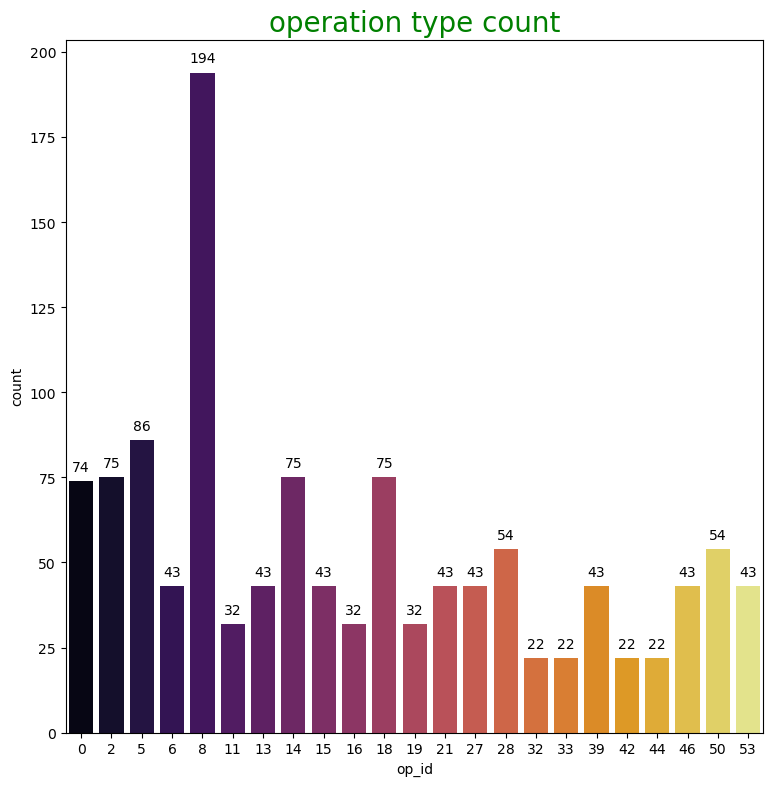

In [157]:
plt.figure(figsize=[9,9])
plot = sns.countplot(df_drop_solo["op_id"], palette = 'inferno')
for p in plot.patches:
    plot.annotate(format(p.get_height(),), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

plt.title('operation type count', fontdict={'fontsize': 20, 'fontweight': 5, 'color': 'Green'})
plt.savefig(f"../../figures/{DATA}/class_and_count_delete_unique_wo_paraphrase.png", bbox_inches='tight')
#plt.xticks(rotation=90)
plt.show()

In [158]:
tr_te_set = df_drop_solo
tr_te_set = tr_te_set.reset_index()
tr_te_set = tr_te_set.drop(columns=["index"])
print(tr_te_set)

      Unnamed: 0                                           Question  \
0              0  What are the areas within a four-minute drive ...   
1              1  What are the four fire stations within 3 minut...   
2              2  What are the land use inside the flood zones i...   
3              3  What area are within 50 km from family physici...   
4              4  What areas are at least 3000 meters from the r...   
...          ...                                                ...   
1210        1210  what expanse are approachable within minutes o...   
1211        1211  what sphere areas are reachable within minutes...   
1212        1212  what areas car reachable within minutes of by ...   
1213        1213  nearest areas are reachable within current of ...   
1214        1214  what areas are reachable within minutes of by ...   

            extents upper level timespan      Tag In Osm Question type  \
0           Utrecht         NaN      NaN             NaN          done   

# 4. Preprocessing

In [159]:
questions = tr_te_set["Question"].str.lower()
labels = tr_te_set["op_id"]

## 4.1 Remove stopword, lemmartization etc...
 pos tag for stamming <br /> 
 ex) <br /> 
 ***before*** "The striped bats are hanging on their feet for best" -> ['The', 'striped', 'bat', 'are', 'hanging', 'on', 'their', 'foot', 'for', 'best'] <br />
 ***after*** "The striped bats are hanging on their feet for best" -> ['The', ***'strip'***, 'bat', ***'be'***, ***'hang'***, 'on', 'their', 'foot', 'for', 'best'] 
 <br />
 <br />
 Also ***delete numbers***, cause those are not that important <br />
 ex) how many buildings are within ***3*** minutes of driving time from fire stations in oleander <br /> -->
 ['how', 'many', 'building', 'be', 'within', 'minute', 'of', 'drive', 'time', 'from', 'fire', 'station', 'in', 'oleander'] <br />
 what are the four fire stations within 3 minutes of travel time from a fire in san francisco <br />
 ['what' 'be' 'the' ***'four'*** 'fire' 'station' 'within' 'unitTime' 'of' 'travel' 'time' 'from' 'a' 'fire' 'in' 'san' 'francisco']

In [160]:
# proccessed vs not processed 비교 해볼 것
# Not Preprocessed
questions_org = [question for question in questions]
# preprocessed
# questions_lem = [preprocess(question) for question in questions]
que_ = questions[5]
lemm = LemmaPlaceTokenizer()
in_ = que_
questions_lem = [" ".join(lemm(question)) for question in questions]
lo_ = 58
print(f"org:{questions_org[lo_]}, \nlem:{questions_lem[lo_]}")


org:what is the median people age for each census tract in tarrant county in texas, 
lem:what be the median people age for each census tract in tarrant county in texas


## 4.2 Vectorize with TfIdf

In [161]:
# vectorizer = TfidfVectorizer()
vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=1, norm='l2', encoding='utf-8',
 stop_words=None,
 )
features = vectorizer.fit_transform(questions_lem).toarray()
features.shape

(1215, 735)

# 5. classify

In [162]:
feature_names = vectorizer.get_feature_names_out()
tfidf = pd.DataFrame(features, columns = feature_names)
tfidf_w_question = tfidf.copy()
tfidf_w_question["Question"] = tr_te_set["Question"]
tfidf_w_question["processed_question"] = questions_lem
tfidf_w_question["op_id"] = tr_te_set["op_id"]
tfidf_w_question["for train"] = tr_te_set["for train"]
tfidf_w_question.to_excel(f"../../data/processed/{DATA}/tfidf_vectorized.xlsx")

In [163]:
Train_test_df = tfidf_w_question.drop(columns=["Question","processed_question"])
train_sample = Train_test_df[Train_test_df["for train"]==True]
X_train = train_sample.drop(columns=["for train","op_id"])
y_train = train_sample["op_id"]
test_sample = Train_test_df[Train_test_df["for train"]==False]
X_test = test_sample.drop(columns=["for train","op_id"])
y_test = test_sample["op_id"]

/Users/heejinchae/opt/anaconda3/envs/torch/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/heejinchae/opt/anaconda3/envs/torch/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/heejinchae/opt/anaconda3/envs/torch/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


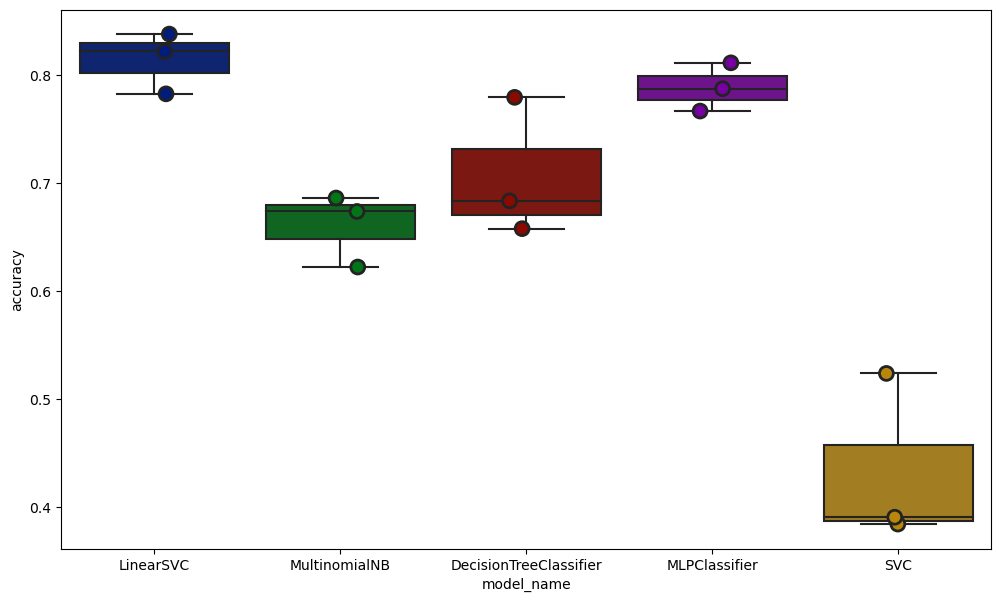

In [164]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier

models = [
    LinearSVC(max_iter=10,random_state=22),
    MultinomialNB(),
    DecisionTreeClassifier(),
    MLPClassifier(),
    SVC(kernel='poly',
    )
]

CV = 3
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

import seaborn as sns
plt.figure(figsize=[12,7])
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=10, jitter=True, edgecolor="gray", linewidth=2)
plt.savefig(f"../../figures/{DATA}/small_classification_wo_paraphrase.png", bbox_inches='tight')
plt.show()

In [165]:
# Accuracy score
cv_df.groupby('model_name').accuracy.mean()

model_name
DecisionTreeClassifier    0.706864
LinearSVC                 0.814023
MLPClassifier             0.788328
MultinomialNB             0.660750
SVC                       0.433170
Name: accuracy, dtype: float64

# Pick model and run

[50 50  0  8  8  8  8  6  6  6  6  0  8  8  8  8  8 53 53 53  8  5  8 19
 19  8 19 19 46 46 46 46 44 39 39 39 14 14  8 15 15 15  2  5  5  5 11 11
  5 11  0  2  5 16 16 28 28 28 28 27 27 27 33 16 11  2 50 21 21 18 18 14
  2 18 14 14 53  0  0 50  0 19  0 13 13 13]
   actual
0      50
1      50
2      14
3       8
4       8
   predict
0       50
1       50
2        0
3        8
4        8
[0, 2, 5, 6, 8, 11, 13, 14, 15, 16, 18, 19, 21, 27, 28, 32, 33, 39, 42, 44, 46, 50, 53]


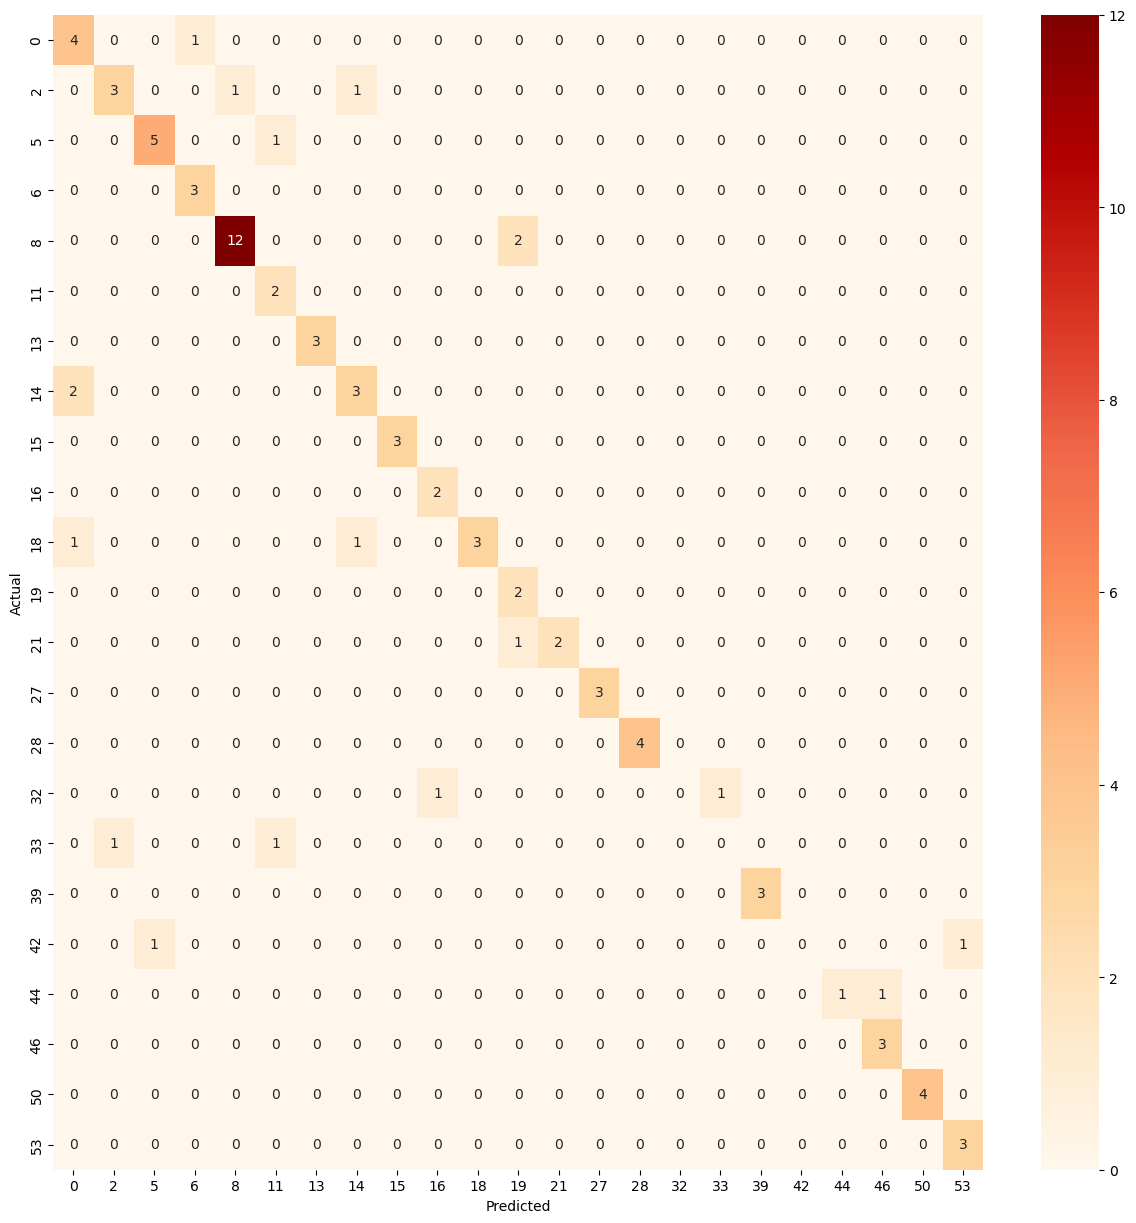

In [166]:
model = LinearSVC()

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(y_pred)

questions_df = tfidf_w_question.copy()
questions_df = questions_df.iloc[X_test.index,:]
questions_df = questions_df[["Question","processed_question","op_id"]]
y_test_df = y_test.to_frame(name="actual")
print(y_test_df.head(5))
y_pred_df = pd.DataFrame(y_pred,index=y_test.index,columns=["predict"])
print(y_pred_df.head(5))
questions_df["actual"] = y_test_df
questions_df["predict"] = y_pred_df
questions_df.to_excel("../../data/processed/prediction_vs_actual.xlsx")



from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
print(sorted(list(set(labels.values))))

fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=sorted(list(set(labels.values))), 
            yticklabels=sorted(list(set(labels.values))),
            cmap='OrRd'
            )
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig("../../figures/tfidf_linsvc_wo_paraphrase_confusion_matrix.png", bbox_inches='tight')
plt.show()

In [167]:
from sklearn import metrics

some_key = tfidf_w_question['op_id'].unique().astype('str').tolist()
print(some_key)
print('accuracy %s' % metrics.accuracy_score(y_pred, y_test))
report = metrics.classification_report(y_test, y_pred, target_names=some_key, output_dict=True)
report_ = metrics.classification_report(y_test, y_pred, target_names=some_key)
report_df = pd.DataFrame(report).transpose()
report_df.to_excel(f"../../data/processed/{DATA}/classification_wo_paraphrase_report.xlsx")
print(report_)

['50', '14', '8', '6', '0', '53', '42', '19', '46', '44', '39', '2', '15', '5', '11', '16', '28', '27', '32', '33', '21', '18', '13']
accuracy 0.7906976744186046
              precision    recall  f1-score   support

          50       0.57      0.80      0.67         5
          14       0.75      0.60      0.67         5
           8       0.83      0.83      0.83         6
           6       0.75      1.00      0.86         3
           0       0.92      0.86      0.89        14
          53       0.50      1.00      0.67         2
          42       1.00      1.00      1.00         3
          19       0.60      0.60      0.60         5
          46       1.00      1.00      1.00         3
          44       0.67      1.00      0.80         2
          39       1.00      0.60      0.75         5
           2       0.40      1.00      0.57         2
          15       1.00      0.67      0.80         3
           5       1.00      1.00      1.00         3
          11       1.00    

/Users/heejinchae/opt/anaconda3/envs/torch/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/heejinchae/opt/anaconda3/envs/torch/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/heejinchae/opt/anaconda3/envs/torch/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

# Visualize

(23, 735)


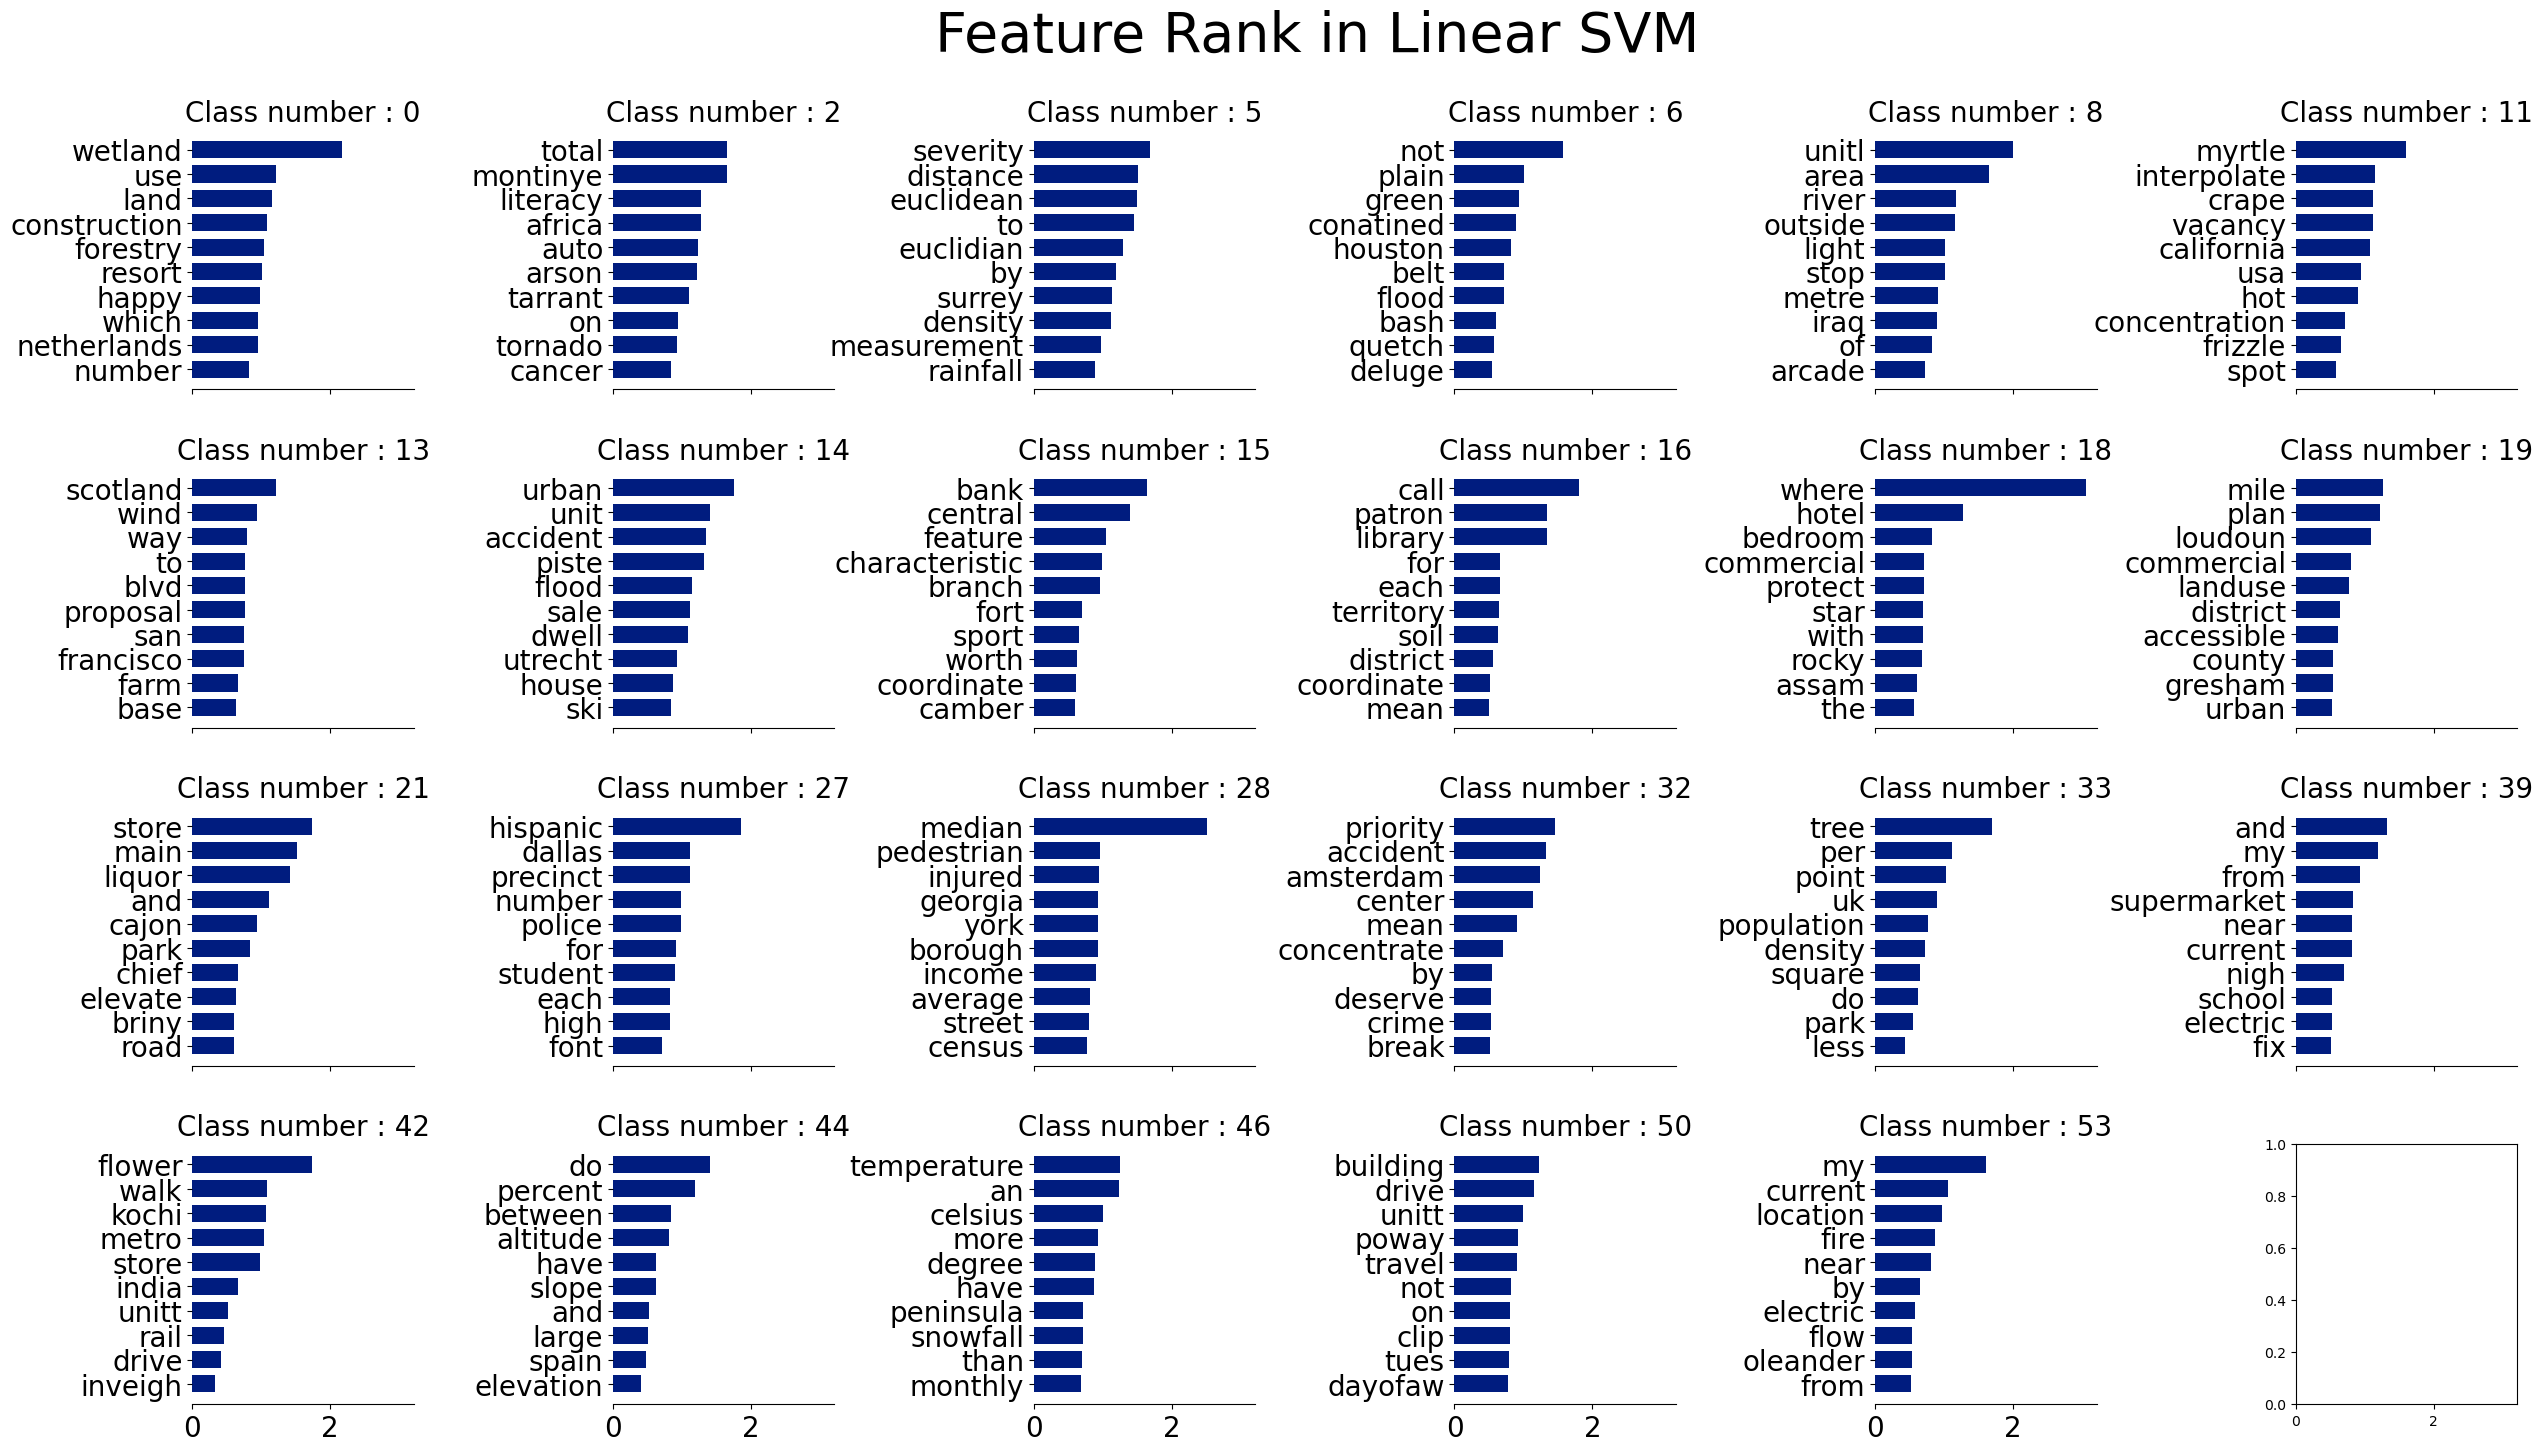

In [168]:
def plot_top_words(isAbs, model, X_train,labels,n_top_words ,feature_names):
    fig_path = f"../../figures/{DATA}feature_rank_abs_in_linear_svm.png"
    coef_effects = np.absolute(model.coef_)
    if isAbs == False:
        fig_path = f"../../figures/{DATA}/feature_rank_pos_in_linear_svm.png"
        coef_effects = model.coef_
    target_names = sorted(list(set(labels.values))) 
    plot_rows = 4
    fig, axes = plt.subplots(plot_rows, 
                             coef_effects.shape[0]//plot_rows if coef_effects.shape[0]%plot_rows == 0 else coef_effects.shape[0]//plot_rows + 1,
                              figsize=(30,15), sharex=True)
    axes = axes.flatten()
    print(coef_effects.shape)
    for topic_idx, topic in enumerate(coef_effects):
        top_features_ind = topic.argsort()[:-n_top_words-1:-1]
        top_features = feature_names[top_features_ind]
        class_number = target_names[topic_idx]
        coef_val = topic[top_features_ind]

        ax = axes[topic_idx] 
        ax.barh(top_features, coef_val, height=0.7)
        ax.set_title(f"Class number : {class_number}", fontdict={"fontsize":20})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle("Feature Rank in Linear SVM", fontsize=40)
    plt.subplots_adjust(top=0.9, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.savefig(fig_path, bbox_inches="tight")
    plt.show()

    return 


_ = plot_top_words(isAbs=False,model=model, X_train= None,labels=labels, n_top_words=10, feature_names=feature_names)